In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

pd.set_option('display.max_rows', 8)

!date
!whoami

Wed Jul 31 14:08:16 PDT 2019
ndbs


In [3]:
import vivarium_conic_sqlns.verification_and_validation.sqlns_output_processing as sop

## Get file paths for locations

In [12]:
!ls /share/costeffectiveness/results/sqlns/presentation/country_comparison/nigeria

2019_07_30_19_24_09


In [18]:
# Base directory for output files. Subdirectories are assumed to be of the form 'location/run_date/'
base_directory = '/share/costeffectiveness/results/sqlns/presentation/country_comparison'

# Map countries to the correct run date = subdirectory name
locations_run_dates = {
    'Bangladesh': '2019_07_30_19_09_43',
    'Burkina_Faso': '2019_07_30_19_15_13',
    'Ethiopia': '2019_07_30_19_18_21',
    'India': '2019_07_30_19_21_23',
    'Nigeria': '2019_07_30_19_24_09',
    }

locations = list(locations_run_dates.keys())

## Load data, check output shapes

In [120]:
all_output = sop.load_by_location_and_rundate(base_directory, locations_run_dates)
sop.print_location_output_shapes(locations, all_output) # Some seeds are missing

Bangladesh (1980, 100)
Burkina_Faso (1974, 100)
Ethiopia (1969, 100)
India (1800, 100)
Nigeria (1980, 100)


In [132]:
# 12 scenarios * 33 input draws * 5 random seeds = 1980 rows expected
12*33*5

1980

## Find index columns (location, intervention, draw)

In [121]:
# Find index columns
all_output.filter(regex='location|sqlns|draw')

,,input_draw,sqlns_treated_days,sqlns.duration,sqlns.program_coverage,location
input_draw_number,random_seed,,,,,
650.0,0.0,650.0,0.0,365.25,0.0,Bangladesh
629.0,43.0,629.0,2993313.0,730.50,0.4,Bangladesh
157.0,48.0,157.0,4629678.0,730.50,0.6,Bangladesh
674.0,48.0,674.0,0.0,365.25,0.0,Bangladesh
...,...,...,...,...,...,...
155.0,30.0,155.0,7797252.5,730.50,1.0,Nigeria
3.0,30.0,3.0,0.0,365.25,0.0,Nigeria
155.0,30.0,155.0,0.0,365.25,0.0,Nigeria
602.0,38.0,602.0,3064648.0,730.50,0.4,Nigeria


In [122]:
intervention_colname_mapper = {
#         'sqlns.effect_on_child_stunting.permanent': 'stunting_permanent',
#         'sqlns.effect_on_child_wasting.permanent': 'wasting_permanent',
#         'sqlns.effect_on_iron_deficiency.permanent': 'iron_permanent',
        'sqlns.duration': 'duration',
#         'sqlns.effect_on_iron_deficiency.mean': 'iron_mean',
#         'sqlns.effect_on_iron_deficiency.sd': 'iron_sd', 
        'sqlns.program_coverage': 'coverage',
    }

index_cols = ['location', 'duration', 'coverage', 'input_draw']

cause_names = ['lower_respiratory_infections', 'measles', 'diarrheal_diseases', 
               'protein_energy_malnutrition', 'iron_deficiency', 'other_causes']

# risk_names = ['anemia', 'child_stunting', 'child_wasting']

## For each location, drop draws that ar missing random seeds

In [123]:
def drop_incomplete_draws(output, num_seeds, num_scenarios):
    row_counts = output.groupby(['location', 'input_draw']).random_seed.count()
    
    combinations = row_counts[row_counts == num_seeds*num_scenarios].reset_index()
    df = output.set_index(['location', 'input_draw']).loc[
        zip(combinations['location'], combinations['input_draw'])].reset_index()
    return df

In [124]:
output = drop_incomplete_draws(all_output, num_seeds=5, num_scenarios=12)
output

,location,input_draw,total_population_untracked,total_population_tracked,total_population,anemia_unexposed_in_2020_among_0_to_5,anemia_mild_in_2020_among_0_to_5,anemia_moderate_in_2020_among_0_to_5,anemia_severe_in_2020_among_0_to_5,anemia_unexposed_in_2021_among_0_to_5,...,sqlns_treated_days,person_time,ylls_due_to_protein_energy_malnutrition,ylls_due_to_lower_respiratory_infections,ylls_due_to_diarrheal_diseases,ylls_due_to_other_causes,years_of_life_lost,simulation_run_time,sqlns.duration,sqlns.program_coverage
0,Bangladesh,3.0,9963.0,9734.0,19697.0,3775.0,3196.0,2910.0,4.0,3736.0,...,0.00,48412.311453,170.305009,3296.519274,605.980353,24628.316340,28701.120976,41520.050991,730.50,0.0
1,Bangladesh,3.0,9956.0,10069.0,20025.0,3833.0,3087.0,2973.0,6.0,3745.0,...,0.00,49015.467805,345.393595,2348.601215,1471.409531,27512.239468,31677.643809,34014.134970,730.50,0.0
2,Bangladesh,3.0,9963.0,9734.0,19697.0,3869.0,3158.0,2855.0,3.0,3945.0,...,3001071.50,48412.311453,170.305009,3296.519274,605.980353,24628.316340,28701.120976,39769.735724,730.50,0.4
3,Bangladesh,3.0,9954.0,9964.0,19918.0,3736.0,3118.0,3009.0,10.0,3651.0,...,0.00,48644.237914,348.760295,2703.161280,1379.591626,24786.739861,29218.253062,38564.414300,365.25,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7016,Nigeria,946.0,9700.0,11519.0,21219.0,3687.0,2260.0,3889.0,228.0,3745.0,...,7760385.50,51546.071194,2328.220957,13303.912297,14206.527900,65314.091297,96857.289225,22049.463409,730.50,1.0
7017,Nigeria,946.0,9716.0,11418.0,21134.0,3749.0,2288.0,3835.0,200.0,3798.0,...,761762.25,51186.505569,2403.442942,13559.532344,13499.249824,66588.964875,97594.587141,21355.758199,365.25,0.2
7018,Nigeria,946.0,9700.0,11519.0,21219.0,3687.0,2260.0,3889.0,228.0,3745.0,...,1560531.25,51546.071194,2328.220957,13303.912297,14206.527900,65314.091297,96857.289225,21404.496258,365.25,0.4
7019,Nigeria,946.0,9715.0,11513.0,21228.0,3706.0,2396.0,3807.0,197.0,3808.0,...,7689590.00,51700.440556,2828.383652,15448.320937,12134.283458,66838.605217,98793.396333,22342.059588,730.50,1.0


## Sum over random seeds, then transform dataframe to long form

In [125]:
df = sop.clean_and_aggregate(output, intervention_colname_mapper, index_cols, 'coverage')
df

total_population_untracked  \
location   duration coverage input_draw                               
Bangladesh 365.25   0.0      3.0                            49778.0   
                             21.0                           49813.0   
                             29.0                           49818.0   
                             55.0                           49768.0   
...                                                             ...   
Nigeria    730.50   100.0    680.0                          48612.0   
                             733.0                          48681.0   
                             829.0                          48415.0   
                             946.0                          48518.0   

                                         total_population_tracked  \
location   duration coverage input_draw                             
Bangladesh 365.25   0.0      3.0                          49539.0   
                             21.0                         49092.0   
                             29.0                         49014.0   
                             55.0                         49130.0   
...                                                           ...   
Nigeria    730.50   100.0    680.0                        57679.0   
                             733.0                        57939.0   
                             829.0                        58839.0   
                             946.0                        58060.0   

                                         total_population  \
location   duration coverage input_draw                     
Bangladesh 365.25   0.0      3.0                  99317.0   
                             21.0                 98905.0   
                             29.0                 98832.0   
                             55.0                 98898.0   
...                                                   ...   
Nigeria    730.50   100.0    680.0               106291.0   
                             733.0               106620.0   
                             829.0               107254.0   
                             946.0               106578.0   

                                         anemia_unexposed_in_2020_among_0_to_5  \
location   duration coverage input_draw                                          
Bangladesh 365.25   0.0      3.0                                       19071.0   
                             21.0                                      22852.0   
                             29.0                                      19823.0   
                             55.0                                      24452.0   
...                                                                        ...   
Nigeria    730.50   100.0    680.0                                     15583.0   
                             733.0                                     14144.0   
                             829.0                                     15249.0   
                             946.0                                     18503.0   

                                         anemia_mild_in_2020_among_0_to_5  \
location   duration coverage input_draw                                     
Bangladesh 365.25   0.0      3.0                                  15639.0   
                             21.0                                 15610.0   
                             29.0                                 15470.0   
                             55.0                                 14273.0   
...                                                                   ...   
Nigeria    730.50   100.0    680.0                                12280.0   
                             733.0                                11910.0   
                             829.0                                12065.0   
                             946.0                                11732.0   

                                         anemia_moderate_in_2020_among_0_to_

In [126]:
# # Testing intermediate step
# sop.get_disaggregated_results(df, cause_names, index_cols)

In [127]:
# # Testing intermediate step
# sop.get_all_cause_results(df, index_cols)

In [128]:
results = sop.get_transformed_data(df, cause_names, index_cols)
results

,location,duration,coverage,input_draw,cause,measure,value,person_time,sqlns_treated_days
0,Bangladesh,365.25,0.0,3.0,diarrheal_diseases,dalys,5825.732351,243259.865573,0.0
1,Bangladesh,365.25,0.0,3.0,diarrheal_diseases,death,65.000000,243259.865573,0.0
2,Bangladesh,365.25,0.0,3.0,diarrheal_diseases,ylds,205.094342,243259.865573,0.0
3,Bangladesh,365.25,0.0,3.0,diarrheal_diseases,ylls,5620.638009,243259.865573,0.0
...,...,...,...,...,...,...,...,...,...
35096,Nigeria,730.50,100.0,946.0,all_causes,death,5641.000000,258499.233057,38729145.0
35097,Nigeria,730.50,100.0,946.0,all_causes,ylls,488775.575449,258499.233057,38729145.0
35098,Nigeria,730.50,100.0,946.0,all_causes,ylds,5712.081289,258499.233057,38729145.0
35099,Nigeria,730.50,100.0,946.0,all_causes,dalys,494487.656738,258499.233057,38729145.0


## Get averted results

In [129]:
averted_df = sop.get_averted_results(results, index_cols, 'coverage')
averted_df

,location,duration,coverage,input_draw,cause,measure,value,person_time,sqlns_treated_days,value_bau,person_time_bau,averted,value_rate,averted_rate,treated_days_per_averted,treated_days_per_averted_rate
0,Bangladesh,365.25,0.0,3.0,diarrheal_diseases,dalys,5825.732351,243259.865573,0.00,5825.732351,243259.865573,0.000000e+00,2394.859644,0.000000e+00,NaN,NaN
1,Bangladesh,365.25,20.0,3.0,diarrheal_diseases,dalys,5825.129316,243262.488434,3887881.75,5825.732351,243259.865573,6.030342e-01,2394.585928,2.737159e-01,6.447199e+06,5.838992e+06
2,Bangladesh,365.25,40.0,3.0,diarrheal_diseases,dalys,5824.488343,243265.264615,7699287.00,5825.732351,243259.865573,1.244008e+00,2394.295113,5.645308e-01,6.189098e+06,5.606383e+06
3,Bangladesh,365.25,60.0,3.0,diarrheal_diseases,dalys,5823.874679,243265.264615,11521995.75,5825.732351,243259.865573,1.857672e+00,2394.042852,8.167920e-01,6.202386e+06,5.798774e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35096,Nigeria,730.50,40.0,946.0,all_causes,dalys,494487.656738,258499.233057,15641623.50,494487.656738,258499.233057,5.820766e-11,191291.730691,2.910383e-11,2.687210e+17,2.079086e+17
35097,Nigeria,730.50,60.0,946.0,all_causes,dalys,494487.656738,258499.233057,23284028.00,494487.656738,258499.233057,5.820766e-11,191291.730691,2.910383e-11,4.000166e+17,3.094915e+17
35098,Nigeria,730.50,80.0,946.0,all_causes,dalys,494487.656738,258499.233057,31004367.50,494487.656738,258499.233057,0.000000e+00,191291.730691,0.000000e+00,inf,inf
35099,Nigeria,730.50,100.0,946.0,all_causes,dalys,494487.656738,258499.233057,38729145.00,494487.656738,258499.233057,5.820766e-11,191291.730691,0.000000e+00,6.653616e+17,inf


## Get aggregated results

In [130]:
aggregated_df = sop.get_final_table(averted_df, index_cols)
aggregated_df

value  \
                                                                 count   
location   duration coverage cause                       measure         
Bangladesh 365.25   0.0      all_causes                  dalys    33.0   
                                                         death    33.0   
                                                         ylds     33.0   
                                                         ylls     33.0   
...                                                                ...   
Nigeria    730.50   100.0    protein_energy_malnutrition dalys    33.0   
                                                         death    33.0   
                                                         ylds     33.0   
                                                         ylls     33.0   

                                                                                 \
                                                                           mean   
location   duration coverage cause                       measure                  
Bangladesh 365.25   0.0      all_causes                  dalys    150396.509049   
                                                         death      1670.515152   
                                                         ylds       4596.479897   
                                                         ylls     145800.029152   
...                                                                         ...   
Nigeria    730.50   100.0    protein_energy_malnutrition dalys     14166.771842   
                                                         death       155.878788   
                                                         ylds        744.971119   
                                                         ylls      13421.800722   

                                                                                \
                                                                           std   
location   duration coverage cause                       measure                 
Bangladesh 365.25   0.0      all_causes                  dalys    14608.935632   
                                                         death      168.547123   
                                                         ylds       909.474709   
                                                         ylls     14713.681630   
...                                                                        ...   
Nigeria    730.50   100.0    protein_energy_malnutrition dalys     2327.041229   
                                                         death       26.952223   
                                                         ylds       165.364581   
                                                         ylls      2320.852615   

                                                                                 \
                                                                            min   
location   duration coverage cause                       measure                  
Bangladesh 365.25   0.0      all_causes                  dalys    122070.460913   
                                                         death      1338.000000   
                                                         ylds       2400.149887   
                                                         ylls     116789.450684   
...                                                                         ...   
Nigeria    730.50   100.0    protein_energy_malnutrition dalys     10140.792280   
                                                         death       110.000000   
                                                         ylds        415.545772   
                                                         ylls       9452.659499   

                                                                                 \
                                                                           2.5%   
location   duration coverage ca

## Save "treated days per averted DALY" to file for plotting ICERS by location

In [141]:
idx = pd.IndexSlice
aggregated_df.loc[
    idx['Bangladesh':'Ethiopia',365.25,40,'all_causes', 'dalys'], 
    'treated_days_per_averted']

,,,,,count,mean,std,min,2.5%,50%,97.5%,max
location,duration,coverage,cause,measure,,,,,,,,
Bangladesh,365.25,40.0,all_causes,dalys,33.0,27188.595992,16666.576034,10167.082792,10296.941313,22860.070350,67920.375272,82087.721303
Burkina_Faso,365.25,40.0,all_causes,dalys,27.0,10461.160993,3685.860145,5351.462490,5501.846385,9758.230618,17865.441844,23837.703534
Ethiopia,365.25,40.0,all_causes,dalys,24.0,12658.357526,4055.671726,6988.719506,7618.152413,11669.330151,22330.801565,24134.686052


In [142]:
aggregated_df.loc[
    idx['Bangladesh':'Ethiopia',365.25,40,'all_causes', 'dalys'], 
    'treated_days_per_averted'].to_csv(
    '/snfs1/Project/simulation_science/mnch/Interventions/sq-lns/presentations/results/'
    'treated_days_per_averted_daly_coverage40.csv'
)

In [143]:
!ls /snfs1/Project/simulation_science/mnch/Interventions/sq-lns/presentations/results/

all_causes_dalys_averted_among_locations.png
all_causes_dalys_averted.csv
all_causes_dalys_averted_nigeria.csv
all_causes_mortality_reduction.csv
nigeria_sensitivity_analysis.png
risk_percentage_points.csv
sqlns_anemia_percentage_points.png
sqlns_child_stunting_percentage_points.png
sqlns_child_wasting_percentage_points.png
sqlns_DALYs_averted_in_Bangladesh.png
sqlns_DALYs_averted_in_Burkina Faso.png
sqlns_DALYs_averted_in_Ethiopia.png
sqlns_DALYs_averted_in_India.png
sqlns_DALYs_averted_in_Nigeria.png
sqlns_Mortality_reduction.png
treated_days_per_averted_daly_coverage40.csv


In [144]:
67/356.25

0.1880701754385965

## Plot ICERs using minimal modification to original code

Oops, it's plotting all locations at once.

In [108]:
measures = averted_df.measure.unique()
averted_cause_list = averted_df.cause.unique()
print(measures, averted_cause_list)

['dalys' 'death' 'ylds' 'ylls'] ['diarrheal_diseases' 'iron_deficiency' 'lower_respiratory_infections'
 'measles' 'other_causes' 'protein_energy_malnutrition' 'all_causes']


In [136]:
days_per_year = 365.25

# @interact()
# def plot_icers(duration=[365.25, 730.50],
#                     cgf_permanent=[False, True],
#                     iron_permanent=[False, True],
#                     iron_mean=[0.895, 4.475, 8.950],
#                               measure=measures,
#                               cause=averted_cause_list,
#                               cost_per_py=cost_slider,
#                   ):
def plot_icers(aggregated_df,
               duration=365.25,
                    cgf_permanent=False,
                    iron_permanent=False,
                    iron_mean=4.475,
                              measure='dalys',
                              cause='all_causes',
                              cost_per_py=67,
                  ):
    
    data = aggregated_df.reset_index()
    
    data = data.loc[(data.duration == duration)
#                   & (data.child_stunting_permanent == cgf_permanent)
#                   & (data.child_wasting_permanent == cgf_permanent)
#                   & (data.iron_deficiency_permanent == iron_permanent)
#                   & (data.iron_deficiency_mean == iron_mean)
                  & (data.cause == cause)
                  & (data.measure == measure)]
    
    fig, ax = plt.subplots(2,2, figsize=(14,9))
    
    xx = data['coverage']
    
    # Plot cost vs. coverage
    mean = cost_per_py * data[('sqlns_treated_days', 'mean')] / days_per_year
    lb = cost_per_py * data[('sqlns_treated_days', '2.5%')] / days_per_year
    ub = cost_per_py * data[('sqlns_treated_days', '97.5%')] / days_per_year
    ax[0,0].plot(xx, mean, '-o')
    ax[0,0].fill_between(xx, lb, ub, alpha=0.8)
    
    # Plot averted measure vs. coverage
    mean = data[('averted', 'mean')]
    lb = data[('averted', '2.5%')]
    ub = data[('averted', '97.5%')]
    ax[1,0].plot(xx, mean, '-o', color='orange')
    ax[1,0].fill_between(xx, lb, ub, alpha=0.1, color='orange')
    
    # Plot ICERs calculated using raw values
    mean = cost_per_py * data[('treated_days_per_averted', 'mean')] / days_per_year
    lb = cost_per_py * data[('treated_days_per_averted', '2.5%')] / days_per_year
    ub = cost_per_py * data[('treated_days_per_averted', '97.5%')] / days_per_year
    ax[0,1].plot(xx, mean, '-o', color='green')
    ax[0,1].fill_between(xx, lb, ub, alpha=0.1, color='green')
    
    # Plot ICERs calculated using rates
    mean = cost_per_py * data[('treated_days_per_averted_rate', 'mean')] / days_per_year
    lb = cost_per_py * data[('treated_days_per_averted_rate', '2.5%')] / days_per_year
    ub = cost_per_py * data[('treated_days_per_averted_rate', '97.5%')] / days_per_year
    ax[1,1].plot(xx, mean, '-o', color='green')
    ax[1,1].fill_between(xx, lb, ub, alpha=0.1, color='green')

    ## Label the plots
    
    ax[0,0].set_title('Total cost vs. coverage', fontsize=16)
    ax[0,0].set_xlabel('Program Coverage (%)', fontsize=12)
    ax[0,0].set_ylabel('Cost of SQ-LNS\ntreatment ($)', fontsize=16)
    ax[0,0].grid()
#         ax[i,0].legend(loc=(0.8, -.25), fontsize=14)

    ax[1,0].set_title(f'Averted {measure} vs. coverage', fontsize=16)
    ax[1,0].set_xlabel('Program Coverage (%)', fontsize=12)
    ax[1,0].set_ylabel(f'Averted {measure}', fontsize=16)
    ax[1,0].grid()

    ax[0,1].set_title('Cost effectiveness (ICERs)\nvs. coverage', fontsize=16)
    ax[0,1].set_xlabel('Program Coverage (%)', fontsize=12)
    ax[0,1].set_ylabel(f'Cost per averted {measure}', fontsize=12)
    ax[0,1].grid()
    
    ax[1,1].set_title('Cost effectiveness (ICERs)\nvs. coverage', fontsize=16)
    ax[1,1].set_xlabel('Program Coverage (%)', fontsize=12)
    ax[1,1].set_ylabel(f'Cost per averted {measure}\n(calculated using rate difference)', fontsize=12)
    ax[1,1].grid()
        
    fig.tight_layout()

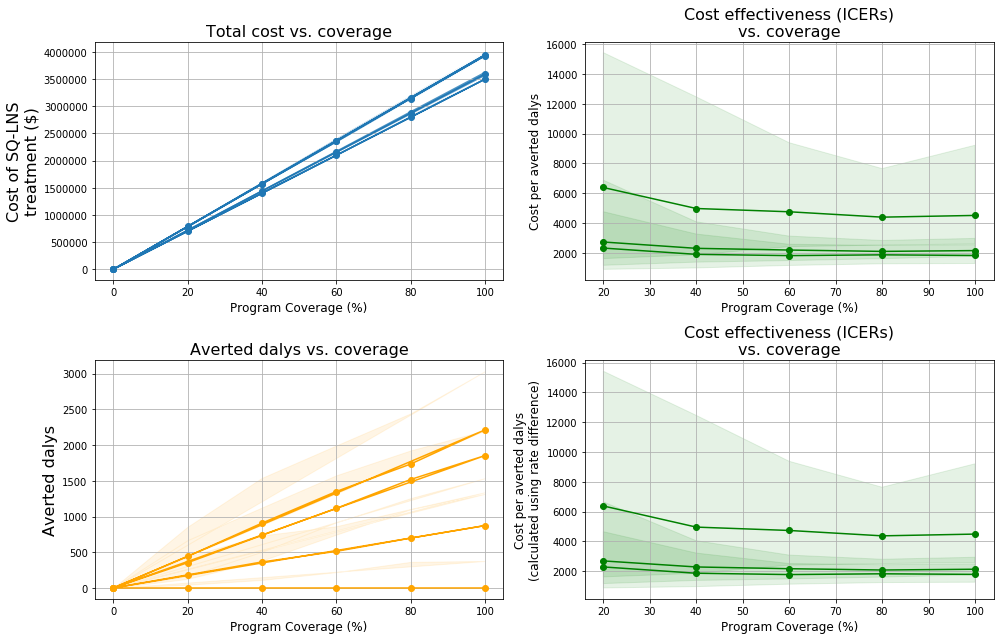

In [137]:
plot_icers(aggregated_df)